# WGU D208 TASK 2 REV 3 - MATTINSON

import required librari

In [1]:
# import standard libraries
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.display import HTML
from IPython.display import display

In [2]:
# import and configure matplotlib
import matplotlib.pyplot as plt
plt.rc("font", size=14)

In [3]:
# import and configure sklearn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import metrics

In [4]:
# import and configure seaborn
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [5]:
# import and configure pandas
import pandas as pd


<div class="impact" data-hdr="Helper Functions">Here are some helper functions that will be used thoughout the notebook. The coorelation matrix helpers were developed courtesy of stackoverflow (2021).</div>

In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def custom_corr_matrix(df, title):
    fig = plt.figure(figsize=(30, 30))
    sns.set(font_scale=1.0)
    sns.heatmap(data=df.corr().round(1), annot=True,annot_kws={'size':30})
    print(get_top_abs_correlations(df))
    #plt.savefig('output/' + COURSE + '/fig_corr_matrix_' + title + '.png', facecolor='w') 
    plt.show()
    
def plot_histogram(c):
    df_yes = df[df.Churn_Yes==1][c]
    df_no = df[df.Churn_Yes==0][c]
    yes_mean = df_yes.mean();
    no_mean = df_no.mean(); 
    fig,ax = plt.subplots(figsize=(6,6))
    ax.hist([df_yes,df_no], bins=5, stacked=True)
    ax.legend(['Churn - Yes','Churn - No'])
    ymin, ymax = ax.get_ylim();
    xmin, xmax = ax.get_xlim()
    ax.axvline(yes_mean, color='blue', lw=2) # yes mean
    ax.axvline(no_mean, color='orangered', lw=2) # no mean
    ax.text((xmax-xmin)/2,
            (ymax-ymin)/2,
            'Delta:\n' + str(round(abs(yes_mean - no_mean),2)),
            bbox={'facecolor':'white'})
    plt.title('Histogram with target overlay by ' + str(c))
    plt.xlabel(c); 
    plt.ylabel('# Churn');
    plt.show();
    
# helper function to plot grouped bar plot
def plot_stacked(c):
    df.groupby([c,target]).size().unstack().plot(kind='bar', stacked=True)

In [7]:
# constants
COURSE = 'd208' # name of course to be added to filename of generated figures and tables.
target = 'Churn' # this is the column name of the primary research column

In [8]:
# read csv file
df = pd.read_csv('data/churn_clean.csv')
df.shape

(10000, 50)

In [9]:
# explore missing data
missing = df[df.columns[df.isna().any()]].columns
df_missing = df[missing]
print(df_missing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Empty DataFrameNone


In [10]:
# look for duplicate data - looking for zero rows
df[df.duplicated()]

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8


In [11]:
# check if any cols are duplicated - Looking for False
df.columns.duplicated().any()

False

In [12]:
# check if any rows are duplicated - looing for False
df.duplicated().any()

False

<div class="impact" data-hdr="Remove Data">Identify columns that are not needed for the analysis and then use the .drop() method to remove the data. Looking at the data, I select some of the demographic data, customer identification data and the survey data to be removed.</div>

In [13]:
# drop unwanted data
cols_to_be_removed = ['City','County','Zip','Job','TimeZone', 'State', 
            'Lat', 'Lng', 'UID', 'Customer_id','Interaction', 'CaseOrder',
            'Item1','Item2','Item3','Item4','Item5','Item6','Item7','Item8']

# print list of dropped data
print('data to be removed: {}'.format(cols_to_be_removed))

# loop through list, if in current df, drop col
for c in cols_to_be_removed:
    if c in df.columns:
        df.drop(columns = c, inplace=True)
        print('Data named [{}] has been removed.'.format(c))

data to be removed: ['City', 'County', 'Zip', 'Job', 'TimeZone', 'State', 'Lat', 'Lng', 'UID', 'Customer_id', 'Interaction', 'CaseOrder', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']
Data named [City] has been removed.
Data named [County] has been removed.
Data named [Zip] has been removed.
Data named [Job] has been removed.
Data named [TimeZone] has been removed.
Data named [State] has been removed.
Data named [Lat] has been removed.
Data named [Lng] has been removed.
Data named [UID] has been removed.
Data named [Customer_id] has been removed.
Data named [Interaction] has been removed.
Data named [CaseOrder] has been removed.
Data named [Item1] has been removed.
Data named [Item2] has been removed.
Data named [Item3] has been removed.
Data named [Item4] has been removed.
Data named [Item5] has been removed.
Data named [Item6] has been removed.
Data named [Item7] has been removed.
Data named [Item8] has been removed.


In [14]:
# print out and describe input variables
for idx, c in enumerate(df.loc[:, df.columns != target]):
    if df.dtypes[c] == "object":
        print('\n{}. {} is categorical: {}.'.format(idx+1,c,df[c].unique()))
        #for idx,name in enumerate(df[c].value_counts().index.tolist()):
        #    print('\t{:<20}:{:>6}'.format(name,df[c].value_counts()[idx]))
        #print('{}'.format(df[c].describe()))
    else:
        print('\n{}. {} is numerical.'.format(idx+1, c))
        #print('{}'.format(df[c].describe().round(3)))
        #groups = df.groupby([target, pd.cut(df[c], bins=4)])
        #print(groups.size().unstack().T)


1. Population is numerical.

2. Area is categorical: ['Urban' 'Suburban' 'Rural'].

3. Children is numerical.

4. Age is numerical.

5. Income is numerical.

6. Marital is categorical: ['Widowed' 'Married' 'Separated' 'Never Married' 'Divorced'].

7. Gender is categorical: ['Male' 'Female' 'Nonbinary'].

8. Outage_sec_perweek is numerical.

9. Email is numerical.

10. Contacts is numerical.

11. Yearly_equip_failure is numerical.

12. Techie is categorical: ['No' 'Yes'].

13. Contract is categorical: ['One year' 'Month-to-month' 'Two Year'].

14. Port_modem is categorical: ['Yes' 'No'].

15. Tablet is categorical: ['Yes' 'No'].

16. InternetService is categorical: ['Fiber Optic' 'DSL' 'None'].

17. Phone is categorical: ['Yes' 'No'].

18. Multiple is categorical: ['No' 'Yes'].

19. OnlineSecurity is categorical: ['Yes' 'No'].

20. OnlineBackup is categorical: ['Yes' 'No'].

21. DeviceProtection is categorical: ['No' 'Yes'].

22. TechSupport is categorical: ['No' 'Yes'].

23. Streaming

In [15]:
def get_unique_values_list(numbers):
    """
    Input:
    numbers: array
    
    Ref: https://www.freecodecamp.org/news/python-unique-list-how-to-get-all-the-unique-values-in-a-list-or-array/
    """
    list_of_unique_numbers = []
    unique_numbers = set(numbers)
    for number in unique_numbers:
        list_of_unique_numbers.append(number)
    return list_of_unique_numbers

In [16]:
for idx, c in enumerate(df.columns):
    if df.dtypes[c] in ('float', 'int', 'int64'):
        print('\n{}. {} is numerical (CONTINUOUS) - type: {}.'.format(idx+1, c, df.dtypes[c]))
        if df.dtypes[c] in ('int', 'int64'):
            numbers = df[c].to_numpy()
            print('  Unique: {}'.format(get_unique_values_list(numbers)))
        if df.dtypes[c] in ('float', 'float64'):
            print('  Min: {:.3f}  Max: {:.3f}  Std: {:.3f}'.format(df[c].min(), df[c].max(),df[c].std()))

    elif df.dtypes[c] == bool:
        print('\n{}. {} is boolean (BINARY): {}.'.format(idx+1,c,df[c].unique()))
    else:
        print('\n{}. {} is categorical (CATEGORICAL): {}.'.format(idx+1,c,df[c].unique())) 


1. Population is numerical (CONTINUOUS) - type: int64.
  Unique: [0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 32801, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 32825, 59, 61, 62, 63, 64, 60, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 32901, 138, 137, 140, 141, 142, 143, 139, 145, 146, 144, 148, 149, 147, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 32929, 163, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 32944, 177, 178, 179, 180, 176, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

In [17]:
# print out and describe target variable
for idx, c in enumerate(df.loc[:, df.columns == target]):
    if df.dtypes[c] == "object":
        print('\n{}. {} is categorical: {}.'.format(idx+1,c,df[c].unique()))
        for idx,name in enumerate(df[c].value_counts().index.tolist()):
            print('\t{:<8}:{:>6}'.format(name,df[c].value_counts()[idx]))
    else:
        print('\n{}. {} is numerical.'.format(idx+1, c))


1. Churn is categorical: ['No' 'Yes'].
	No      :  7350
	Yes     :  2650


<div class="impact" data-hdr="Numeric vs Cateogrical Data">The analysis will use the following variables to separate the numeric and categorical data.</div>

In [18]:
# variable for numeric data
num_cols = df.select_dtypes(include="number").columns
print(num_cols)

Index(['Population', 'Children', 'Age', 'Income', 'Outage_sec_perweek',
       'Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year'],
      dtype='object')


In [19]:
# variable for categorical data
cat_cols = df.select_dtypes(include="object").columns
print(cat_cols)

Index(['Area', 'Marital', 'Gender', 'Churn', 'Techie', 'Contract',
       'Port_modem', 'Tablet', 'InternetService', 'Phone', 'Multiple',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


<h2 data-nbr="Cx">Explore Target Data</h2>

<div class="impact" data-hdr="Explore Target Data">Display a data table and count plot of the target data. Also, calculate percentages of churn and not churned customers in order to determine if the data is balanced or not.</div>

No     7350
Yes    2650
Name: Churn, dtype: int64


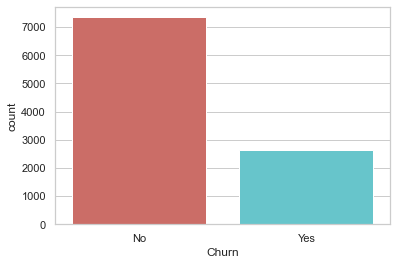

In [20]:
print(df[target].value_counts())
sns.countplot(x=target, data=df, palette='hls')
plt.show()

In [21]:
# calculate balance
count_no_churn = len(df[df[target]=='No'])
count_churn = len(df[df[target]=='Yes'])
pct_of_no_churn = count_no_churn/(count_no_churn+count_churn)
pct_of_churn = count_churn/(count_no_churn+count_churn)
print('% of customers that did not churn: {:.1%}'.format(pct_of_no_churn ))
print('% of customers that did churn: {:.1%}'.format(pct_of_churn ))

% of customers that did not churn: 73.5%
% of customers that did churn: 26.5%


<div class="impact" data-hdr="Unbalanced Data">
    Observe that the target data is not balanced.
  </div>


In [22]:
# describe numerical mean data compared to target
df.groupby(target).mean().round(2).T

Churn,No,Yes
Population,9830.51,9551.46
Children,2.09,2.07
Age,53.01,53.27
Income,39706.40,40085.76
Outage_sec_perweek,10.00,10.00
Email,11.99,12.08
Contacts,0.99,1.01
Yearly_equip_failure,0.40,0.38
Tenure,42.23,13.15
MonthlyCharge,163.01,199.30


<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>The <b>Income</b> of churned customers is slightly higher.
    <li>The <b>Tenure</b> of churned customers is significantly lower.
    <li>The <b>MonthlyCharge</b> of churned customers is considerable higher.
    <li>The <b>Bandwidth_GB_Year</b> is significantly lower.        
</ul>

<h2 data-nbr="Cx">Explore Predictor Data</h2>

<div class="impact" data-hdr="Explore Categorical Data">
    Prior to converting the categorical data for use in the model, as part of exploratory data analysis, I will visualize the original categorical data using a countplot. In a moment, the categorical data will be converted to dummy data and I will lose the original data.
  </div>

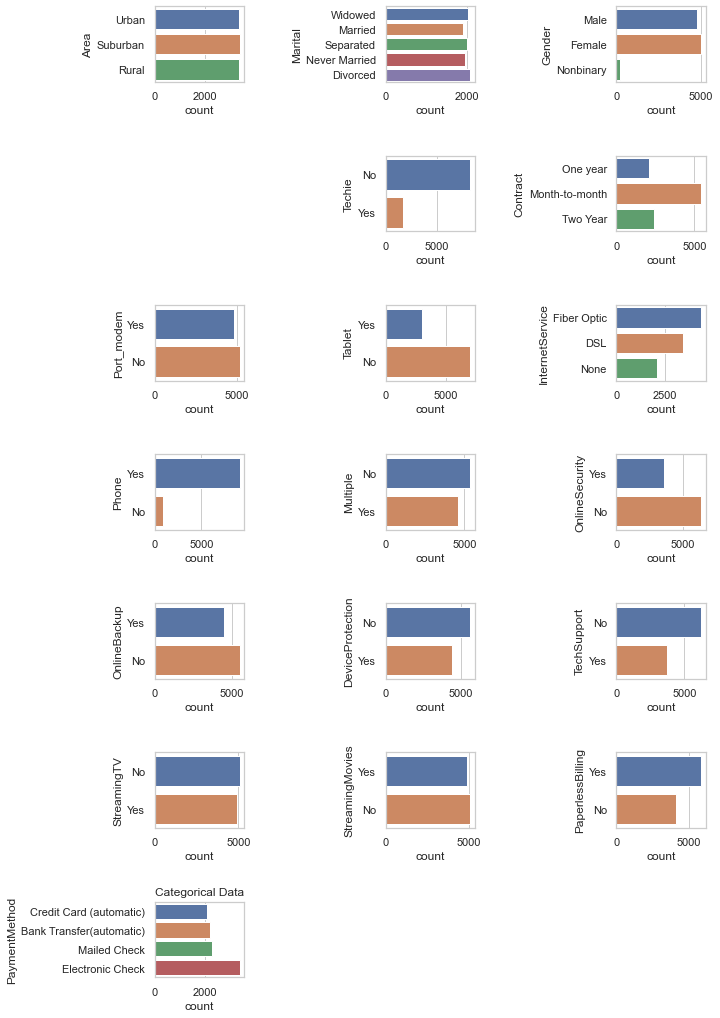

In [23]:
# plot categorical data - before it gets converted
fig = plt.figure(figsize=(10, 20))

for i, col in enumerate(cat_cols):
    if col != target:
        plt.subplot(10, 3, i+1)
        ax = sns.countplot(y=col, data=df)
        fig.tight_layout(h_pad=4, w_pad=4)

plt.title('Categorical Data')
plt.show()

<div class="impact" data-hdr="Explore Categorical Data - Means By Unique Value">
    Show mean values for all categorical unique values compared to other numeric data. Explore mean data for each of the categorical variables using pandas' function .groupby().mean().
  </div>

In [25]:
# print out mean values of numeric data for a given variable 
for c in cat_cols:
    if c != target:
        print('\n\n======================================')
        print('\t{}'.format(c.upper()))
        print('======================================')
        print(df.groupby(c).mean().round(2).T)



	AREA
Area                     Rural  Suburban     Urban
Population             9732.35   9993.76   9542.22
Children                  2.11      2.08      2.07
Age                      52.71     53.23     53.30
Income                39667.13  39909.15  39843.92
Outage_sec_perweek        9.99     10.03      9.99
Email                    12.05     11.98     12.02
Contacts                  1.00      0.99      1.00
Yearly_equip_failure      0.40      0.40      0.39
Tenure                   35.14     34.37     34.07
MonthlyCharge           172.49    172.49    172.90
Bandwidth_GB_Year      3442.81   3380.28   3354.00


	MARITAL
Marital               Divorced   Married  Never Married  Separated   Widowed
Population             9720.79   9743.90       10271.33    9454.70   9608.61
Children                  2.08      2.11           2.08       2.09      2.09
Age                      53.53     52.84          53.33      52.81     52.86
Income                39738.42  40330.36       40021.84   391

<div class="impact" data-hdr="Explore Categorical Data - Grouped Bar Plot with Target Overlay">
    Grouped bar plot of each categorical data with target data overlaid.
  </div>

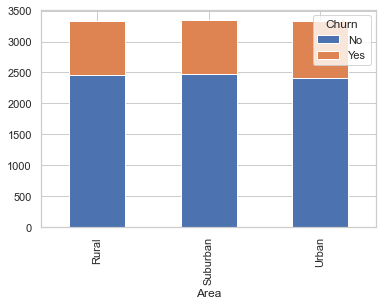

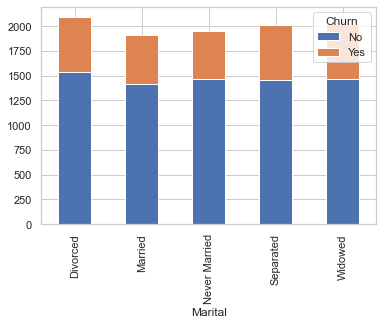

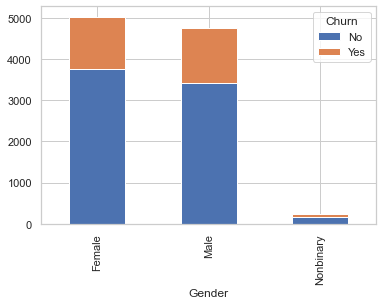

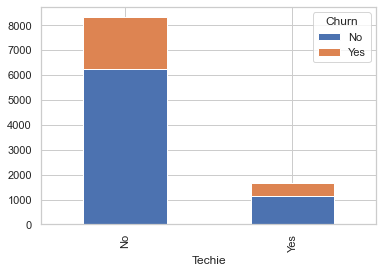

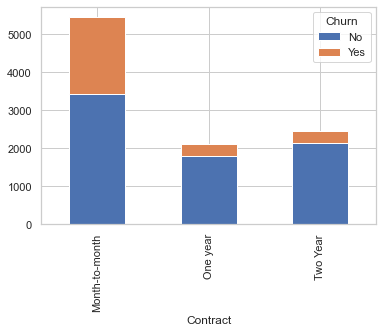

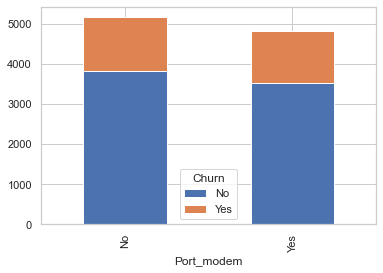

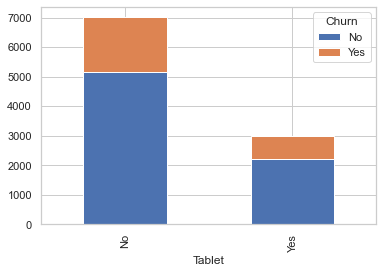

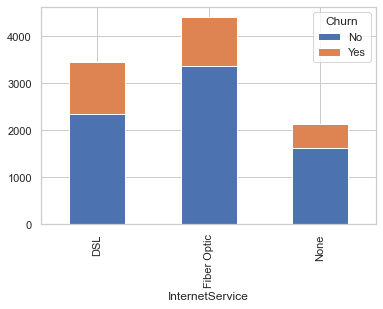

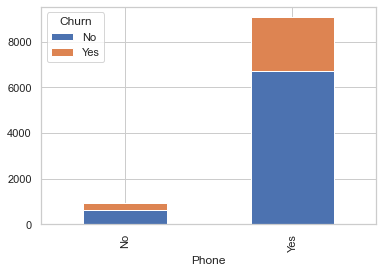

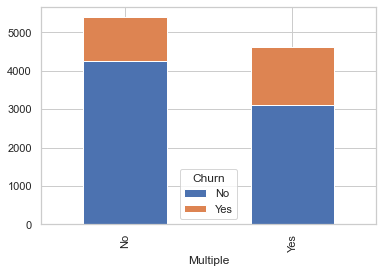

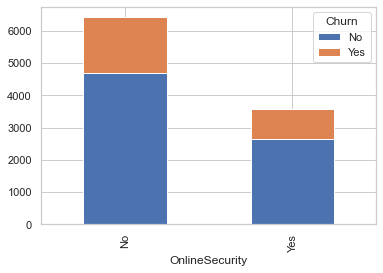

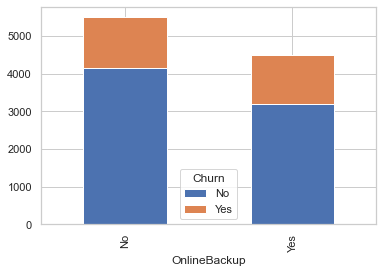

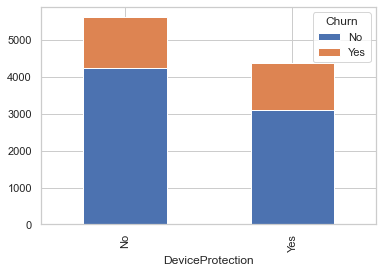

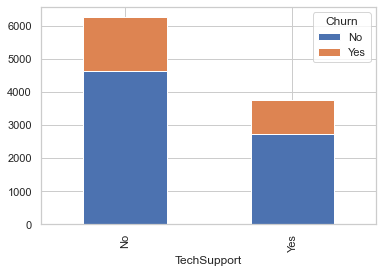

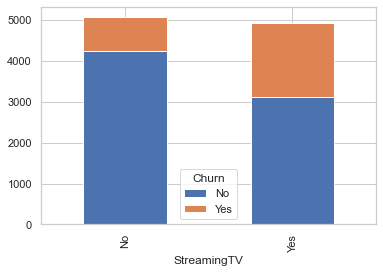

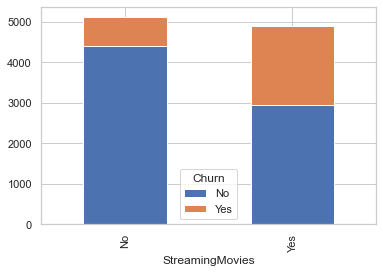

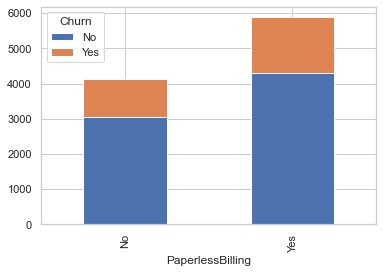

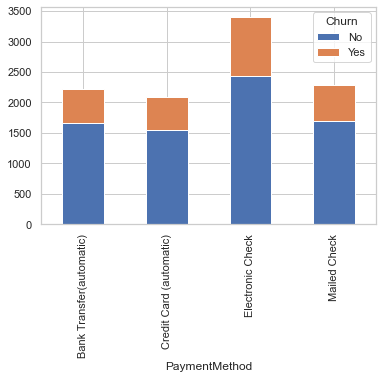

In [26]:
# plot each variable vs. target overlay
for c in cat_cols:
    if c != target:
        plot_stacked(c)

<div class="impact" data-hdr="Good Predictors">Based on the plots, it appears that the following variables might be good predictors of the outcome:</div>
<ul class="a">
    <li><b>Marital</b>
    <li><b>Gender</b>
    <li><b>Techie</b>
    <li><b>Contract</b>
    <li><b>Tablet</b>
    <li><b>InternetService</b>
    <li><b>OnlineSecurity</b> - maybe
    <li><b>OnlineBackup</b> - maybe
    <li><b>TechSupport</b> - maybe
    <li><b>StreamingTV</b>
    <li><b>StreamingMovies</b>
    <li><b>PaperlessBilling</b>
    <li><b>PaymentMethod</b>
</ul>

<div class="impact" data-hdr="Convert Selected Categorical Data">Now that I have selected some of the categorical data that seem to be a good predictors of the outcome, I will convert these categorical data to dummy, numeric data. Each new variable will have a value of either one (1) or zero (0).</div>

In [27]:
# convert categorical data
for c in cat_cols:
    if c in df.columns:
        df = pd.get_dummies(df, columns=[c], drop_first=False)
pred_vars = df.select_dtypes(include="uint8").columns.tolist()
print(pred_vars)

['Area_Rural', 'Area_Suburban', 'Area_Urban', 'Marital_Divorced', 'Marital_Married', 'Marital_Never Married', 'Marital_Separated', 'Marital_Widowed', 'Gender_Female', 'Gender_Male', 'Gender_Nonbinary', 'Churn_No', 'Churn_Yes', 'Techie_No', 'Techie_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two Year', 'Port_modem_No', 'Port_modem_Yes', 'Tablet_No', 'Tablet_Yes', 'InternetService_DSL', 'InternetService_Fiber Optic', 'InternetService_None', 'Phone_No', 'Phone_Yes', 'Multiple_No', 'Multiple_Yes', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Bank Transfer(automatic)', 'PaymentMethod_Credit Card (automatic)', 'PaymentMethod_Electronic Check', 'PaymentMethod_Mailed Check']


In [30]:
# reset the global target variable using its dummy variable
target = 'Churn_Yes'

In [31]:
df.shape

(10000, 58)

<div class="impact" data-hdr="Describe Numeric Data">Traditional statistics for numeric data.</div>

In [34]:
# describe numeric data
df[num_cols].describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Population,10000.0,9756.562,14432.699,0.000,738.000,2910.500,13168.000,111850.000
Children,10000.0,2.088,2.147,0.000,0.000,1.000,3.000,10.000
Age,10000.0,53.078,20.699,18.000,35.000,53.000,71.000,89.000
Income,10000.0,39806.927,28199.917,348.670,19224.718,33170.605,53246.170,258900.700
Outage_sec_perweek,10000.0,10.002,2.976,0.100,8.018,10.019,11.969,21.207
Email,10000.0,12.016,3.026,1.000,10.000,12.000,14.000,23.000
Contacts,10000.0,0.994,0.988,0.000,0.000,1.000,2.000,7.000
Yearly_equip_failure,10000.0,0.398,0.636,0.000,0.000,0.000,1.000,6.000
Tenure,10000.0,34.526,26.443,1.000,7.918,35.431,61.480,71.999
MonthlyCharge,10000.0,172.625,42.943,79.979,139.979,167.485,200.735,290.160


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Population                              10000 non-null  int64  
 1   Children                                10000 non-null  int64  
 2   Age                                     10000 non-null  int64  
 3   Income                                  10000 non-null  float64
 4   Outage_sec_perweek                      10000 non-null  float64
 5   Email                                   10000 non-null  int64  
 6   Contacts                                10000 non-null  int64  
 7   Yearly_equip_failure                    10000 non-null  int64  
 8   Tenure                                  10000 non-null  float64
 9   MonthlyCharge                           10000 non-null  float64
 10  Bandwidth_GB_Year                       10000 non-null  flo

<div class="impact" data-hdr="Univariate Histogram Plot of Numeric Predictor Data">Here are the histogram plots for numeric data.</div>

<Figure size 720x1440 with 0 Axes>

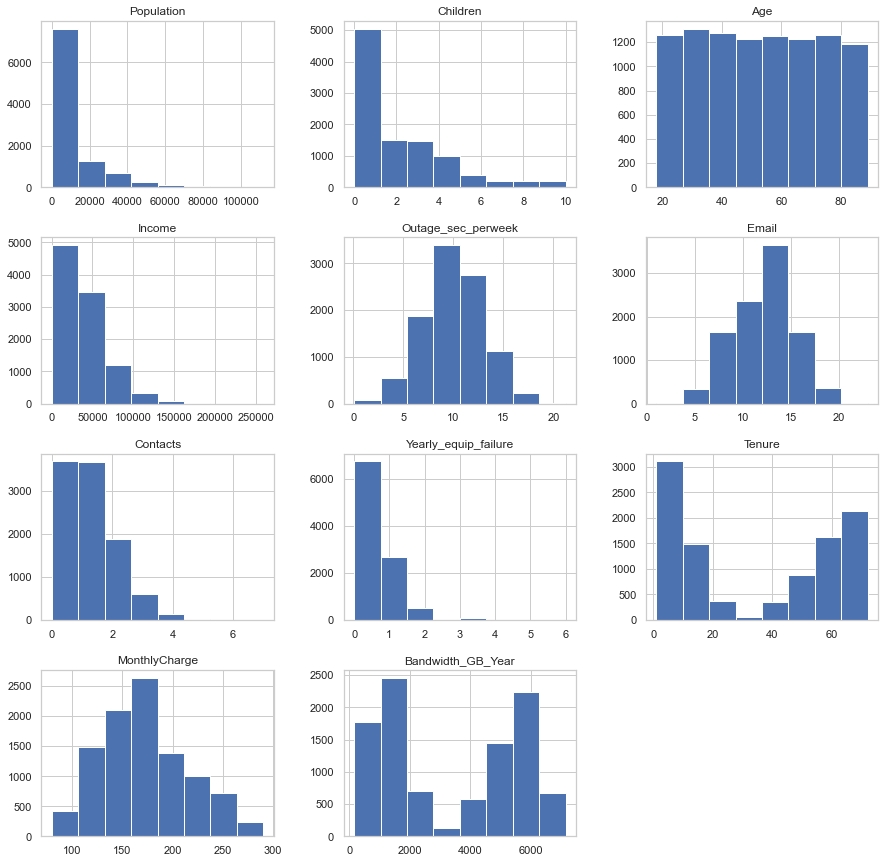

In [36]:
# histogram plot numeric data
fig = plt.figure(figsize=(10, 20))
ax = df[num_cols].hist(bins = 8, figsize=(15,15))
plt.title('Numeric Data')
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()

<div class="impact" data-hdr="Bivariate Barplot of Numeric Predictor Data">Here are the histogram plots for the numeric data. Each of these plots show the frequency counts based on the yes or no value of the target variable.</div>

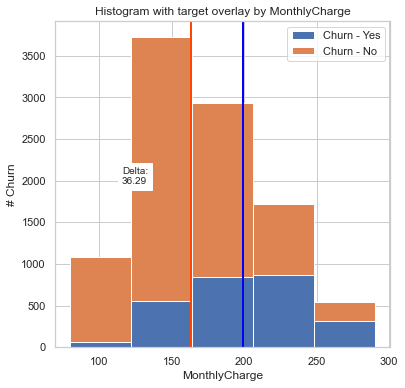

In [41]:
# create histogram with target overlay
plot_histogram('MonthlyCharge')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>The mean value for churned customers is 36.29 units higher.      
</ul>

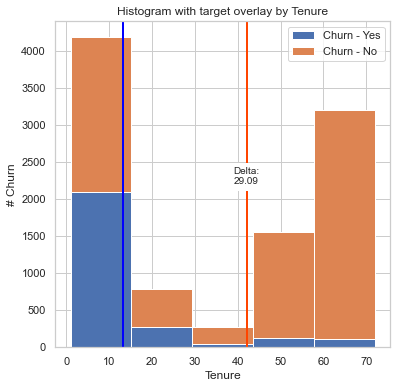

In [43]:
# create histogram with target overlay
plot_histogram('Tenure')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>The mean value for churned customers is 29.09 units lower.      
</ul>

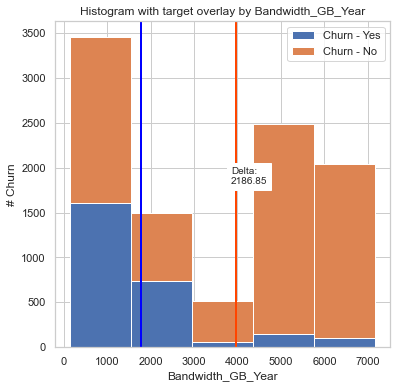

In [45]:
# create histogram with target overlay
plot_histogram('Bandwidth_GB_Year')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>The mean value for churned customers is 2186.85 units lower.      
</ul>

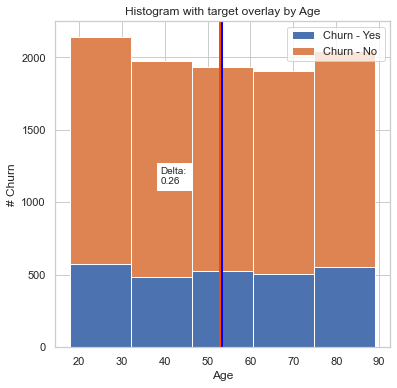

In [46]:
# create histogram with target overlay
plot_histogram('Age')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

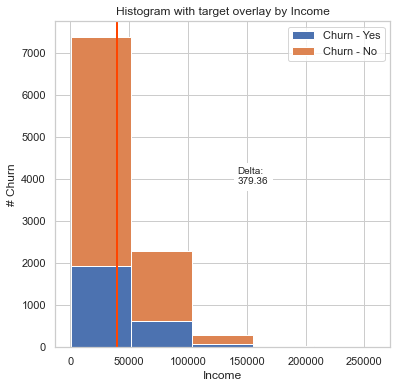

In [47]:
# create histogram with target overlay
plot_histogram('Income')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

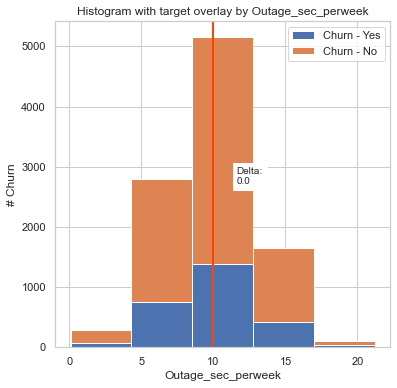

In [48]:
# create histogram with target overlay
plot_histogram('Outage_sec_perweek')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

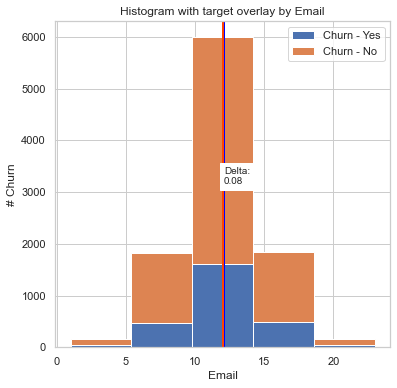

In [49]:
# create histogram with target overlay
plot_histogram('Email')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

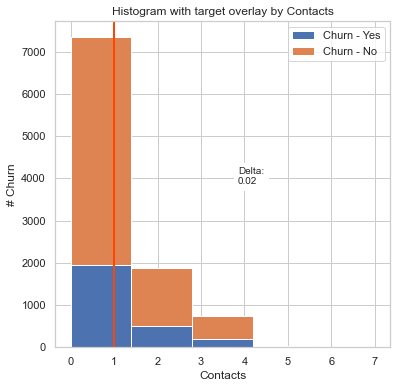

In [50]:
# create histogram with target overlay
plot_histogram('Contacts')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

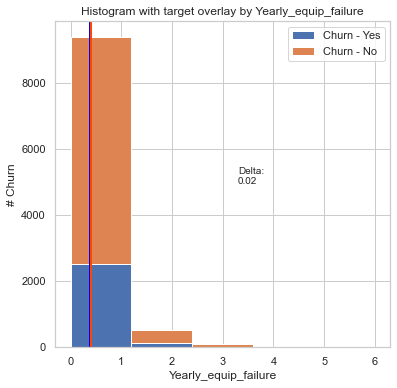

In [51]:
# create histogram with target overlay
plot_histogram('Yearly_equip_failure')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

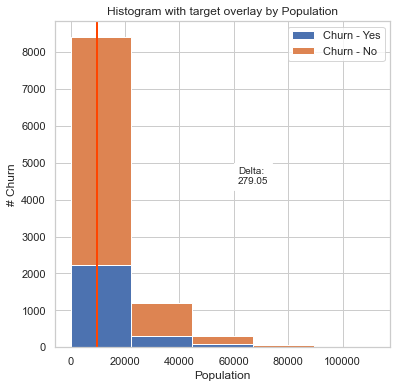

In [52]:
# create histogram with target overlay
plot_histogram('Population')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

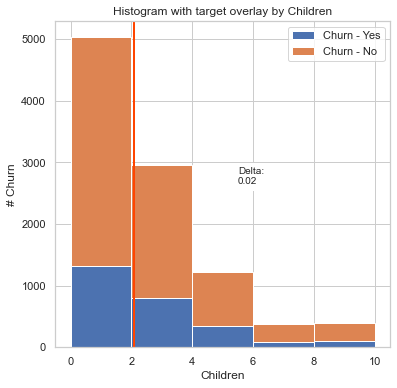

In [53]:
# create histogram with target overlay
plot_histogram('Children')

<div class="impact" data-hdr="Observations">Observations:
  </div>
<ul class="a">
    <li>There appears to be no distinction between churned and non-churned customers.      
</ul>

<div class="impact" data-hdr="Drop Data">Need to get rid of the variable <b>Churn_No</b> in order to prevent collinearity with <b>Churn_Yes</b> </div>

In [54]:
# drop unwanted data
cols_to_be_removed = ['Churn_No','Gender_Female']

# print list of dropped data
print('data to be removed: {}'.format(cols_to_be_removed))

# loop through list, if in current df, drop col
for c in cols_to_be_removed:
    if c in df.columns:
        df.drop(columns = c, inplace=True)
        print('Data named [{}] has been removed.'.format(c))

data to be removed: ['Churn_No', 'Gender_Female']
Data named [Churn_No] has been removed.
Data named [Gender_Female] has been removed.


<h2 data-nbr="C5">Provide Copy of Data</h2>

<div class="impact" data-hdr="Final Data">Here is the final list of columns after all data cleaning.</div>

In [ ]:
# Provide copy of the prepared data set.
final_data = 'd208_task2_final_data.csv'
df.to_csv(final_data, index=False, header=True)
print('File saved to: {}'.format(final_data))
print(df.columns.to_series().groupby(df.dtypes).groups)

<div class="part">Model Comparison and Analysis</div>

<h2 data-nbr="D1">Initial Model</h2>

<div class="impact" data-hdr="Balance Data">We saw earlier that the data is not balanced, so I am using the SMOTE package to oversample the data in order to balance out the data before running the model.</div>

In [56]:
%pip install imblearn


     ------------------------------------- 199.1/199.1 kB 11.8 MB/s eta 0:00:00


In [57]:
# rebalance data using SMOTE oversample
X = df.loc[:, df.columns != 'Churn_Yes']
y = df.loc[:, df.columns == 'Churn_Yes']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Churn_Yes'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no churn in oversampled data",len(os_data_y[os_data_y['Churn_Yes']==0]))
print("Number of churn",len(os_data_y[os_data_y['Churn_Yes']==1]))
print("Proportion of no churn data in oversampled data is ",len(os_data_y[os_data_y['Churn_Yes']==0])/len(os_data_X))
print("Proportion of churn data in oversampled data is ",len(os_data_y[os_data_y['Churn_Yes']==1])/len(os_data_X))

length of oversampled data is  10298
Number of no churn in oversampled data 5149
Number of churn 5149
Proportion of no churn data in oversampled data is  0.5
Proportion of churn data in oversampled data is  0.5


<div class="impact" data-hdr="RFE Feature Reduction">RFE in the sklearn package finds and ranks the features with the most potential to the model.</div>

In [59]:
# RFE feature reduction
data_final_vars=df.columns.values.tolist()
y=[target]
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
features =[]
print('The following features are selected:')
for i in range(os_data_X.shape[1]):
    if rfe.support_[i] == True:
        features.append(os_data_X.columns[i])
        print('Column: %d, Rank: %.3f, Feature: %s' % 
          (i, rfe.ranking_[i],
           os_data_X.columns[i]))

The following features are selected:


NameError: name 'rfe' is not defined

<div class="impact" data-hdr="Intial Model">Use the RFE features analysis above to select the best features for the initial iteration of the model.</div>

In [ ]:
# initial model
X=os_data_X[features] # from RFE above
Xc = sm.add_constant(X) # reset
y=os_data_y[target]
logit_model=sm.Logit(y,Xc)
result=logit_model.fit()
print(result.summary2())

<div class="impact" data-hdr="Confusion Matrix - Initial Model">Display confusion matrix of the test and prediction data from the intial model.</div>

In [ ]:
# confustion matrix for initial model

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
predicted = lgr.predict(X_test)
expected = y_test
confusion = pd.DataFrame(confusion_matrix(y_true=expected, y_pred=predicted),
                    index=range(2),columns=range(2))
axes = sns.heatmap(confusion, annot=True,cmap='nipy_spectral_r', fmt='g')

In [ ]:
# calculate number and percent of predictions
correct = sum(np.diagonal(confusion)) # on diag
total = confusion.values.sum()
incorrect = total - correct # off diag
print('Correct predictions on diagonal: {} ({:.0%})'.format( correct, correct / total ))
print('Incorrect predictions off diagonal: {} ({:.0%})'.format( incorrect, incorrect / total )) 

<div class="impact" data-hdr="High Coorelation">Use coorelation matrix to find predictor pairs with high coorelation.</div>

In [ ]:
# find predictor pairs with high coorelation
#custom_corr_matrix(X,'Model_2')
get_top_abs_correlations(X, 20)

<h2 data-nbr="D3">Reduced Model</h2>

<div class="impact" data-hdr="Final Model">Remove features with high P-values or high multi-collinearity. It looks like there are a few of the input variables that have high multi-collinearity. Then re-run the model.</div>

In [ ]:
# update model
features.remove('Gender_Nonbinary') # high p-value
features.remove('Outage_sec_perweek') # high p-value
features.remove('Email') # high p-value
features.remove('Marital_Not_Married') # high p-value
features.remove('Area_Urban') # high collinearity
features.remove('InternetService_None') # high collinearity
X=os_data_X[features]
y=os_data_y[target]
Xc = sm.add_constant(X) # reset
logit_model=sm.Logit(y,Xc)
result=logit_model.fit()
print(result.summary2())

<div class="impact" data-hdr="Confusion Matrix - Final Model">Display confusion matrix of the test and prediction data.</div>

In [ ]:
# confustion matrix for final model
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
predicted = lgr.predict(X_test)
expected = y_test
confusion = pd.DataFrame(confusion_matrix(y_true=expected, y_pred=predicted),
                    index=range(2),columns=range(2))
axes = sns.heatmap(confusion, annot=True,cmap='nipy_spectral_r', fmt='g')

In [ ]:
# calculate number and percent of predictions
correct = sum(np.diagonal(confusion)) # on diag
total = confusion.values.sum()
incorrect = total - correct # off diag
print('Correct predictions on diagonal: {} ({:.0%})'.format( correct, correct / total ))
print('Incorrect predictions off diagonal: {} ({:.0%})'.format( incorrect, incorrect / total )) 

<div class="impact" data-hdr="Classification Report">Classification report below:</div>

In [ ]:
# classification report
print(classification_report(expected, predicted))

<div class="impact" data-hdr="ROC Curve">ROC curve below:</div>

In [ ]:
# plot ROC Curve
logit_roc_auc = roc_auc_score(y_test, lgr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lgr.predict_proba(X_test)
[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' %logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# equation of the regression line/plane
print('Logit: {:.2f}'.format(logit_roc_auc))
equation = result.summary2().tables[1]
print('Estimate [{}] as L = '.format(result.summary2().tables[0][1][1]))
for i in equation.itertuples():
    print('   {:+.3f} x ( {} ) '.format(i[1],i[0]))

In [ ]:
# visualization of the log coef using exp(x) plot
import matplotlib.pyplot as plt
X_coeff = []
for i in equation.itertuples():
    X_coeff.append(i[1])
X_coeff.sort()
x = X_coeff
y = np.exp(x)
plt.figure()
plt.plot(X_coeff, y, color="red", marker="+")
plt.xlim([-7.0, 2.0])
plt.ylim([-1.0, 3.0])
plt.xlabel('$x$')
plt.ylabel('$\exp(x)$')
plt.show()